In [1]:
#!source ../activate_conda.sh
import processor.FCNC_fake_rate_measurement as fr
import matplotlib.pyplot as plt
import awkward as ak

from coffea import processor, hist
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import Weights, PackedSelection

import numpy as np
import pandas as pd
from yahist import Hist1D, Hist2D

# this is all very bad practice
from Tools.objects import *
from Tools.basic_objects import *
from Tools.cutflow import *
from Tools.config_helpers import *
from Tools.triggers import *
from Tools.btag_scalefactors import *
from Tools.lepton_scalefactors import *
from Tools.nano_mapping import make_fileset, nano_mapping
from processor.meta_processor import get_sample_meta
from plots.helpers import makePlot, scale_and_merge

In [2]:
from klepto.archives import dir_archive
from processor.default_accumulators import desired_output, add_processes_to_output, dataset_axis, pt_axis, eta_axis

from Tools.helpers import get_samples
from Tools.config_helpers import redirector_ucsd, redirector_fnal
from Tools.nano_mapping import make_fileset

overwrite = True

# load the config and the cache
cfg = loadConfig()

cacheName = 'nano_analysis'
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)
histograms = sorted(list(desired_output.keys()))

year = 2018

samples = get_samples(f_in='samples_testQCD.yaml')

fileset = make_fileset(['testQCD'], samples, redirector=redirector_ucsd, small=True)
print(fileset)

add_processes_to_output(fileset, desired_output)
pt_axis_mu = hist.Bin("pt", r"$p_{T}$ (GeV)", [10., 15., 25.,  35., 50.])
eta_axis_mu =  hist.Bin("eta", r"$p_{T}$ (GeV)", [0, 1.2, 2.1, 2.4])
pt_axis_e = hist.Bin("pt", r"$p_{T}$ (GeV)", [0, 25., 35., 45., 65., 100])
eta_axis_e =  hist.Bin("eta", r"$p_{T}$ (GeV)", [0, 1.479, 2.5])

desired_output.update({
    "single_mu_fakeable": hist.Hist("Counts", dataset_axis, pt_axis_mu, eta_axis_mu),
    "single_mu": hist.Hist("Counts", dataset_axis, pt_axis_mu, eta_axis_mu),
    "muons_p": processor.column_accumulator(np.zeros(shape=(0,15)))
})

exe_args = {
    'workers': 16,
    'function_args': {'flatten': False},
    "schema": NanoAODSchema,
    "skipbadfiles": True,
}
exe = processor.futures_executor

if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    print ("I'm running now")

    output = processor.run_uproot_job(
        fileset,
        "Events",
        fr.nano_analysis(year=year, variations=[], accumulator=desired_output),
        exe,
        exe_args,
        chunksize=250000,
    )

    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()

#get weights and scale data
meta = get_sample_meta(fileset, samples)
my_hists = {}
my_hists['single_mu_fakeable'] = scale_and_merge(output['single_mu_fakeable'], meta, fileset, nano_mapping)
my_hists['single_mu'] = scale_and_merge(output['single_mu'], meta, fileset, nano_mapping)
events_p = pd.DataFrame(data=output["muons_p"].value, columns=["pt","conePt","eta","dz","dxy","ptErrRel", "miniPFRelIso_all", "jetRelIsoV2", "jetRelIso", "jetPtRelv2", "event", "MET_PT", "mt", "num_tight_mu", "num_loose_mu"])

{'/QCD_Pt-120to170_MuEnrichedPt5_TuneCP5_13TeV_pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM': ['root://xcache-redirector.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/QCD_Pt-120to170_MuEnrichedPt5_TuneCP5_13TeV_pythia8/NANOAODSIM/Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/70000/DE335891-829A-B943-99BE-E5A179F5F3EB.root']}
I'm running now


Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/3 [00:00<?, ?chunk/s]

Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/1 [00:00<?, ?chunk/s]

(<matplotlib.image.AxesImage at 0x7fc7f15c2ee0>, <AxesSubplot:>)

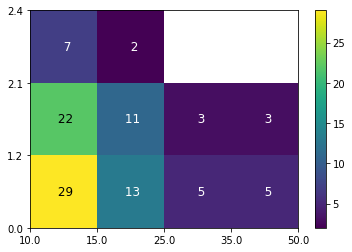

In [3]:
tight_mu_hist = output["single_mu"]
def make_yahist(x):
    x_axis_0 = x.axes()[0].name
    x_axis_1 = x.axes()[1].name
    yahist_x = Hist2D.from_bincounts(x.values()[()].T, (x.axis(x_axis_0).edges(), x.axis(x_axis_1).edges()))
    return yahist_x
make_yahist(tight_mu_hist.sum("dataset")).plot(show_counts=True, equidistant='xy')

In [4]:
fakeable_mu_hist = output["single_mu_fakeable"]
tight_mu_hist = output["single_mu"]
mu_true_positive = output["single_mu_true_positive"]
mu_false_positive = output["single_mu_false_positive"]
mu_true_negative = output["single_mu_true_negative"]
mu_false_negative = output["single_mu_false_megative"]
fakeable_mu_hist_weighted = my_hists["single_mu_fakeable"]
tight_mu_hist_weighted = my_hists["single_mu"]

In [5]:
# import uproot
# tree = uproot.open('root://xcache-redirector.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/QCD_Pt-15to20_EMEnriched_TuneCP5_13TeV_pythia8/NANOAODSIM/Nano02Apr2020_102X_upgrade2018_realistic_v21_ext1-v1/120000/DBBFA116-54FD-1F49-99EA-A95187A4D14C.root')['Events']
# tree.arrays(['MET_pt'])
def make_yahist(x):
    x_axis_0 = x.axes()[0].name
    x_axis_1 = x.axes()[1].name
    yahist_x = Hist2D.from_bincounts(x.values()[()].T, (x.axis(x_axis_0).edges(), x.axis(x_axis_1).edges()))
    return yahist_x

def divide_2D_hist(x, y):
    x_axis_0 = x.axes()[0].name
    x_axis_1 = x.axes()[1].name
    y_axis_0 = y.axes()[0].name
    y_axis_1 = y.axes()[1].name
    yahist_x = Hist2D.from_bincounts(x.values()[()].T, (x.axis(x_axis_0).edges(), x.axis(x_axis_1).edges()))
    yahist_y = Hist2D.from_bincounts(y.values()[()].T, (y.axis(y_axis_0).edges(), y.axis(y_axis_1).edges()))
    return yahist_x.divide(yahist_y)

In [6]:
# pt_bins = hist.Bin("pt", r'$P_{T}\ GeV$', [0, 25., 35., 45., 65., 120.])#[[0, 25.],[25., 35.], [35., 45.], [45., 65.], [65., 120.]])
# eta_bins_mu = hist.Bin('eta', r'$eta\ (GeV)$',[-2.5, -1.2, 1.2,  2.5])
# eta_bins_e = hist.Bin('eta', r'$eta\ (GeV)$',[-2.5, -1.5, 1.5, 2.5])
rebinned_fakeable_mu_hist = fakeable_mu_hist#.rebin('pt', pt_bins).rebin('eta', eta_bins_mu)
rebinned_fakeable_e_hist = fakeable_e_hist#.rebin('pt', pt_bins).rebin('eta', eta_bins_e)

rebinned_fakeable_mu_hist_weighted = fakeable_mu_hist_weighted#.rebin('pt', pt_bins).rebin('eta', eta_bins_mu)
rebinned_fakeable_e_hist_weighted = fakeable_e_hist_weighted#.rebin('pt', pt_bins).rebin('eta', eta_bins_e)

rebinned_tight_mu_hist = tight_mu_hist#.rebin('pt', pt_bins).rebin('eta', eta_bins_mu)
rebinned_tight_e_hist = tight_e_hist#.rebin('pt', pt_bins).rebin('eta', eta_bins_e)

rebinned_tight_mu_hist_weighted = tight_mu_hist_weighted#.rebin('pt', pt_bins).rebin('eta', eta_bins_mu)
rebinned_tight_e_hist_weighted = tight_e_hist_weighted#.rebin('pt', pt_bins).rebin('eta', eta_bins_e)

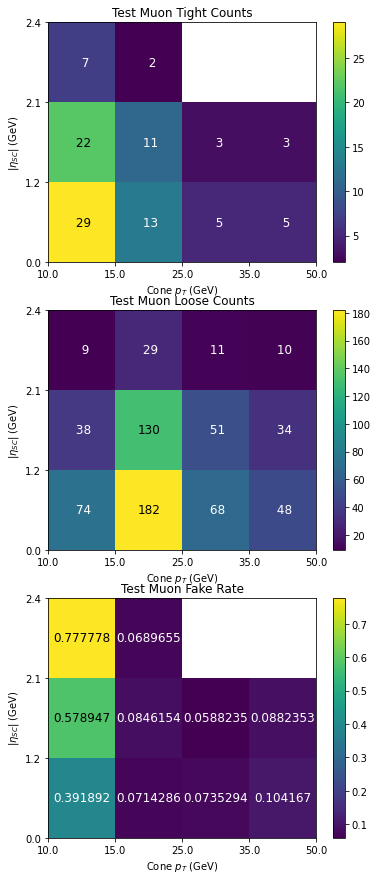

In [7]:
fig, ax = plt.subplots(3, 1, figsize = (6,15))

make_yahist(tight_mu_hist.sum("dataset")).plot(show_counts=True, equidistant='xy', ax=ax[0])
ax[0].set_xlabel(r'Cone $p_T$ (GeV)')
ax[0].set_ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
ax[0].set_title('Test Muon Tight Counts')


make_yahist(fakeable_mu_hist.sum("dataset")).plot(show_counts=True, equidistant='xy', ax=ax[1])
ax[1].set_xlabel(r'Cone $p_T$ (GeV)')
ax[1].set_ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
ax[1].set_title('Test Muon Loose Counts')

num_mu = tight_mu_hist.sum('dataset')
denom_mu = (fakeable_mu_hist).sum('dataset')
divide_2D_hist(num_mu, denom_mu).plot(show_counts=True, equidistant='xy', ax=ax[2])
ax[2].set_xlabel(r'Cone $p_T$ (GeV)')
ax[2].set_ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
ax[2].set_title('Test Muon Fake Rate')

plt.savefig("/home/users/cmcmahon/public_html/fake_rates/fr_debugging.pdf")
plt.show()

In [14]:
bin_reqs_all = (events_p["MET_PT"] < 20)# & (events_p["mt"] < 20) & (events_p["conePt"] < 100)
bin_reqs = [bin_reqs_all & (events_p["conePt"] > 10) & (events_p["conePt"] < 15) & (events_p["eta"] > -1.2) & (events_p["eta"] < 1.2),
            bin_reqs_all & (events_p["conePt"] > 15) & (events_p["conePt"] < 25) & (events_p["eta"] > -1.2) & (events_p["eta"] < 1.2),
            bin_reqs_all & (events_p["conePt"] > 25) & (events_p["conePt"] < 35) & (events_p["eta"] > -1.2) & (events_p["eta"] < 1.2),
            bin_reqs_all & (events_p["conePt"] > 35) & (events_p["conePt"] < 50) & (events_p["eta"] > -1.2) & (events_p["eta"] < 1.2),
            bin_reqs_all & (events_p["conePt"] > 10) & (events_p["conePt"] < 15) & (((events_p["eta"] > 1.2) & (events_p["eta"] < 2.1)) | ((events_p["eta"] > -2.1) & (events_p["eta"] < -1.2))),
            bin_reqs_all & (events_p["conePt"] > 15) & (events_p["conePt"] < 25) & (((events_p["eta"] > 1.2) & (events_p["eta"] < 2.1)) | ((events_p["eta"] > -2.1) & (events_p["eta"] < -1.2))),
            bin_reqs_all & (events_p["conePt"] > 25) & (events_p["conePt"] < 35) & (((events_p["eta"] > 1.2) & (events_p["eta"] < 2.1)) | ((events_p["eta"] > -2.1) & (events_p["eta"] < -1.2))),
            bin_reqs_all & (events_p["conePt"] > 35) & (events_p["conePt"] < 50) & (((events_p["eta"] > 1.2) & (events_p["eta"] < 2.1)) | ((events_p["eta"] > -2.1) & (events_p["eta"] < -1.2))),
            bin_reqs_all & (events_p["conePt"] > 10) & (events_p["conePt"] < 15) & (((events_p["eta"] > 2.1) & (events_p["eta"] < 2.4)) | ((events_p["eta"] > -2.4) & (events_p["eta"] < -2.1))),
            bin_reqs_all & (events_p["conePt"] > 15) & (events_p["conePt"] < 25) & (((events_p["eta"] > 2.1) & (events_p["eta"] < 2.4)) | ((events_p["eta"] > -2.4) & (events_p["eta"] < -2.1))),
            bin_reqs_all & (events_p["conePt"] > 25) & (events_p["conePt"] < 35) & (((events_p["eta"] > 2.1) & (events_p["eta"] < 2.4)) | ((events_p["eta"] > -2.4) & (events_p["eta"] < -2.1))),
            bin_reqs_all & (events_p["conePt"] > 35) & (events_p["conePt"] < 50) & (((events_p["eta"] > 2.1) & (events_p["eta"] < 2.4)) | ((events_p["eta"] > -2.4) & (events_p["eta"] < -2.1)))]
bin_reqs_pt = [bin_reqs_all & (events_p["pt"] > 20) & (events_p["pt"] < 32) & (events_p["eta"] > -1.2) & (events_p["eta"] < 1.2),
            bin_reqs_all & (events_p["pt"] > 32) & (events_p["pt"] < 45) & (events_p["eta"] > -1.2) & (events_p["eta"] < 1.2),
            bin_reqs_all & (events_p["pt"] > 45) & (events_p["pt"] < 65) & (events_p["eta"] > -1.2) & (events_p["eta"] < 1.2),
            bin_reqs_all & (events_p["pt"] > 65) & (events_p["pt"] < 100) & (events_p["eta"] > -1.2) & (events_p["eta"] < 1.2),
            bin_reqs_all & (events_p["pt"] > 20) & (events_p["pt"] < 32) & ((events_p["eta"] > 1.2) | (events_p["eta"] < -1.2)),
            bin_reqs_all & (events_p["pt"] > 32) & (events_p["pt"] < 45) & ((events_p["eta"] > 1.2) | (events_p["eta"] < -1.2)),
            bin_reqs_all & (events_p["pt"] > 45) & (events_p["pt"] < 65) & ((events_p["eta"] > 1.2) | (events_p["eta"] < -1.2)),
            bin_reqs_all & (events_p["pt"] > 65) & (events_p["pt"] < 100) & ((events_p["eta"] > 1.2) | (events_p["eta"] < -1.2))]
#events_p["eta"] < 1.2) & (events_p["eta"] > -1.2) & (events_p["pt"] < 100) & (events_p["pt"] > 65) & 
bin_names = ["(1,1)","(1,2)","(1,3)","(1,4)","(2,1)","(2,2)","(2,3)","(2,4)","(3,1)","(3,2)","(3,3)","(3,4)"]
events_p[bin_reqs[0]]
events_p.loc[events_p["event"]==6886009]

,pt,conePt,eta,dz,dxy,ptErrRel,miniPFRelIso_all,jetRelIsoV2,jetRelIso,jetPtRelv2,event,MET_PT,mt,num_tight_mu,num_loose_mu
83,44.99382,44.99382,1.706543,-0.000856,-0.000556,0.017363,0.057,0.185547,0.185547,7.953125,6886009.0,12.700964,13.494292,1.0,1.0


In [15]:
events_p[bin_reqs[5]]

,pt,conePt,eta,dz,dxy,ptErrRel,miniPFRelIso_all,jetRelIsoV2,jetRelIso,jetPtRelv2,event,MET_PT,mt,num_tight_mu,num_loose_mu
3,18.539206,20.569687,1.837158,0.004887,-0.001152,0.019595,0.061529,0.320312,0.320312,3.000000,7896111.0,6.031283,1.570752,1.0,1.0
5,14.284933,16.326250,1.813721,0.017532,0.000517,0.015860,0.077298,0.326172,0.326172,3.390625,526408.0,9.270802,1.312403,1.0,1.0
15,18.163023,20.026251,-1.969482,0.002037,0.001083,0.020861,0.014504,0.300781,0.300781,4.734375,3140633.0,8.090804,3.745090,1.0,1.0
27,24.848488,24.848488,1.653564,-0.018570,0.003883,0.013519,0.041494,0.160645,0.160645,5.718750,980038.0,5.141170,16.598331,1.0,1.0
34,22.806967,24.026875,1.311279,0.006039,-0.000597,0.015415,0.103753,0.271484,0.271484,0.869141,8170981.0,15.173571,16.507889,1.0,1.0
44,18.129477,18.129477,-1.980469,0.000122,0.000995,0.021115,0.033262,-0.079834,-0.079834,16.562500,235569.0,9.584761,8.354908,1.0,1.0
63,16.083590,16.083590,-1.964111,-0.011101,0.004864,0.026230,0.025350,0.021973,0.021973,8.250000,2000142.0,15.503331,5.371009,1.0,1.0
67,14.113585,15.967813,-1.488525,-0.003723,-0.001387,0.016468,0.048512,0.310547,0.310547,0.258789,2673249.0,7.325833,12.506455,1.0,1.0
80,16.718496,18.569376,1.581787,0.015503,-0.002436,0.017056,0.077330,0.314453,0.314453,2.882812,8367722.0,19.339050,7.297684,1.0,1.0
94,18.109673,18.962500,-2.046875,-0.024643,-0.007011,0.022433,0.000000,0.220215,0.220215,4.312500,5815099.0,3.520234,5.137002,1.0,1.0


In [16]:
bin_test = events_p[bin_reqs_all]
bin_test.to_csv("/home/users/cmcmahon/public_html/fake_rates/csv/all.csv")
for b in range(len(bin_reqs)):
    tmp = events_p[bin_reqs[b]]
    tmp.to_csv("/home/users/cmcmahon/public_html/fake_rates/csv/bin_{}.csv".format(bin_names[b]))

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (10,10))

make_yahist(mu_true_positive.sum("dataset")).plot(show_counts=True, equidistant='xy', ax=ax[0,0])
ax[0,0].set_xlabel(r'Cone $p_T$ (GeV)')
ax[0,0].set_ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
ax[0,0].set_title('Test Muon Tight Counts')


make_yahist(fakeable_mu_hist.sum("dataset")).plot(show_counts=True, equidistant='xy', ax=ax[1])
ax[1].set_xlabel(r'Cone $p_T$ (GeV)')
ax[1].set_ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
ax[1].set_title('Test Muon Loose Counts')

In [ ]:
plt.figure("QCD_mu_fake_rate", figsize = (10,10))
divide_2D_hist(num_mu, denom_mu).plot(show_counts=True, equidistant='xy')
#plt.xticks(np.arange(0, 130, 10))
plt.xlabel(r'Cone $p_T$ (GeV)')
plt.ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
plt.title('QCD Muon Fake Rate')
plt.show()

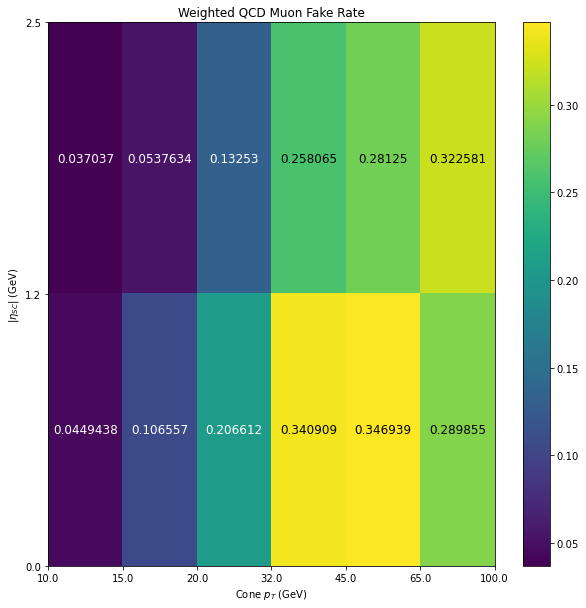

In [35]:
plt.figure("QCD_mu_fake_rate_weighted", figsize = (10,10))
divide_2D_hist(num_mu_weighted, denom_mu_weighted).plot(show_counts=True, equidistant='xy')
#plt.xticks(np.arange(0, 130, 10))
plt.xlabel(r'Cone $p_T$ (GeV)')
plt.ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
plt.title('Weighted QCD Muon Fake Rate')
plt.show()